In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import random
import bisect

from collections import defaultdict
from collections import Counter
import random
import sys
import pickle

sys.path.insert(0,'../decryption')
sys.path.insert(0,'../encryption')
sys.path.insert(0,'../dictionaries')

import encrypt
import decrypt
import alphabet
import frequency

_ALPHABET = " abcdefghijklmnopqrstuvwxyz"

In [2]:
# simulation of problem
TEST_KEY_MAPPING = encrypt.generate_key_mapping()
TEST_CHAR_MAPPING = encrypt.char_key_mapping_from_key_mapping(TEST_KEY_MAPPING)

assert len(set(TEST_KEY_MAPPING)) == 27

TEST_PLAIN_TEXTS = []
with open('../dictionaries/official_dictionary_1_cleaned.txt','r') as f:
    content = f.readlines()
    for line in content:
        TEST_PLAIN_TEXTS.append(line.strip())

TEST_PROBABILITY = 0.1
ciphers = [encrypt.encrypt(msg,TEST_KEY_MAPPING,TEST_PROBABILITY) for msg in TEST_PLAIN_TEXTS]

# pick a random cipher and start working with it. (We should not know the original plain text)
r = random.randint(0,len(ciphers)-1)
cipher_txt = ciphers[r]
test_plain_text = TEST_PLAIN_TEXTS[r]

In [3]:
def build_rel_dist(text):
    rel_dist = defaultdict(list)
    rel_num = defaultdict(list)
    for j,c in enumerate(text):
        rel_dist[c].append((j/len(text)))
        rel_num[c].append(j)
    return rel_dist,rel_num

def get_diff(arr):
    diff = []
    for i in range(1,len(arr)):
        diff.append(round(arr[i]-arr[i-1],4))
    return diff

In [4]:
rel_dist_all = [build_rel_dist(text) for text in TEST_PLAIN_TEXTS]
rel_dists = [a[0] for a in rel_dist_all]
rel_nums = [a[1] for a in rel_dist_all]

rel_dist_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_dists]
rel_num_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_nums]

c_rel_dist,c_rel_num = build_rel_dist(cipher_txt)

c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})
c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})


In [182]:
# strategy: First declare eliminations 
# Then Declare hyperparameters as thresholds. For different values of extra characters, calculate the best
# value of these hyperparameters by running through the solution

# elimination 1: length of rel should be lesser
# elimination 2: top r (hyper param mapped to diff) values of p_vals
# elimination 3: check difference in first character of rel num. it should be less than k (2nd hyper-parameter OR ML input)
# elimination 4: for each term in first and last m (3rd hyperparam) rel dist elements, 
# find closest term and add difference of square from it to total score. Choose letter with lowest such score
#       OR
# Do this for first m terms in rel nums
#       OR
# Calculate some group stats and run a classification ML model. These features can include:
# diff, 1st, 2nd, 3rd ... kth moment of steps of both distributions (k is a hyperparameter)

# In the end, calculate average p value of each guess and output the maximum
# OR calculate score as p value * size in rel num

In [5]:
def iter_tests(p,num):
    """
    iterate over num tests for prob p
    """
    for _ in range(num):
        num_key_mapping = encrypt.generate_key_mapping()
        char_key_mapping = encrypt.char_key_mapping_from_key_mapping(num_key_mapping)

        r = random.randint(0,len(ciphers)-1)
        cipher = encrypt.encrypt(TEST_PLAIN_TEXTS[r],num_key_mapping,p)

        yield r,cipher,char_key_mapping

def append(data,df):
    l = len(df)
    for k,v in data.items():
        df.loc[l,k] = v

In [6]:
def get_space_diffs_left(space_rel_num,rel_num):
    ret = []
    for i,num in enumerate(rel_num):
        space_closest = bisect.bisect_left(space_rel_num,num) - 1

        if space_closest == -1:
            ret.append(num)
            continue
        ret.append(num - space_rel_num[space_closest])
    return ret

In [7]:
def get_char_diffs_data(char_rel_num,rel_num,l):
    left = []
    right = []
    avg_num_diff = []
    for i,num in enumerate(rel_num):
        char_closest_right = bisect.bisect_left(char_rel_num,num)
        char_closest_left = char_closest_right-1
        if char_closest_left == -1:
            lo = 0
        else:
            lo = char_rel_num[char_closest_left]
        if char_closest_right == len(char_rel_num):
            hi = l
        else:
            hi = char_rel_num[char_closest_right]
        left.append(num-lo)
        right.append(hi-num)
        avg_num_diff.append(right[-1] - left[-1])
        
    return left,right,avg_num_diff

In [392]:
r_idx,cipher,char_key_mapping = next(iter_tests(0.4,1))
c_rel_dist,c_rel_num = build_rel_dist(cipher)
diff = len(cipher)-len(TEST_PLAIN_TEXTS[r_idx])

In [417]:
target = 'c'
rel_num = rel_nums[r_idx][target]
space_rel_num = rel_nums[r_idx][' ']

In [418]:
space_left_p = get_space_diffs_left(rel_nums[r_idx][' '],rel_nums[r_idx][target])
space_char = decrypt.get_space_key_value(cipher)
space_left_c = get_space_diffs_left(c_rel_num[space_char],c_rel_num[char_key_mapping[target]])

In [505]:
for target in _ALPHABET:
    rel_num = rel_nums[r_idx][target]
    space_rel_num = rel_nums[r_idx][' ']
    space_left_p,space_right_p,space_avg_p = get_char_diffs_data(rel_nums[r_idx][' '],rel_nums[r_idx][target],len(TEST_PLAIN_TEXTS[r_idx]))
    space_char = decrypt.get_space_key_value(cipher)
    space_left_c,space_right_c,space_avg_c = get_char_diffs_data(c_rel_num[space_char],c_rel_num[char_key_mapping[target]],len(cipher))
    
    print(round(np.mean(space_left_c) - np.mean(space_left_p),3))
    print(round(np.std(space_left_c) - np.std(space_left_p),3))

9.434
11.225
9.348
7.589
9.186
8.145
11.224
8.367
9.123
7.47
10.578
8.24
12.392
8.866
8.076
8.582
8.254
5.875
9.384
7.477
11.459
9.053
10.564
11.474
7.535
6.88
9.639
7.933
11.002
7.462
9.187
7.389
10.183
7.746
nan
nan
10.119
9.043
9.156
8.431
9.239
7.522
11.592
9.291
8.631
9.03
13.601
8.657
7.545
10.455
9.306
7.998
6.12
8.119


In [8]:
def get_data(
    num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,
    space_data_c,space_data_p,last_char_data_c,last_char_data_p
    ):
    data = dict()
    
    data['l_c_dist'] = len(c_dist)
    data['l_dist'] = len(dist)
    
    last_char_left_c,last_char_right_c,last_char_avg_c = last_char_data_c
    last_char_left_p,last_char_right_p,last_char_avg_p = last_char_data_p
    
    if last_char_left_c:
        data['last_char_left_c_mean'] = np.mean(last_char_left_c)
        data['last_char_left_c_std'] = np.std(last_char_left_c)
        
    if last_char_right_c:
        data['last_char_right_c_mean'] = np.mean(last_char_right_c)
        data['last_char_right_c_std'] = np.std(last_char_right_c)
        
    if last_char_avg_c:
        data['last_char_diff_c_mean'] = np.mean(last_char_avg_c)
        data['last_char_diff_c_std'] = np.std(last_char_avg_c)
    
    if last_char_left_p:
        data['last_char_left_p_mean'] = np.mean(last_char_left_p)
        data['last_char_left_p_std'] = np.std(last_char_left_p)
        
    if last_char_right_p:
        data['last_char_right_p_mean'] = np.mean(last_char_right_p)
        data['last_char_right_p_std'] = np.std(last_char_right_p)
        
    if last_char_avg_c:
        data['last_char_diff_p_mean'] = np.mean(last_char_avg_p)
        data['last_char_diff_p_std'] = np.std(last_char_avg_p)
    
    space_left_c,space_right_c,space_avg_c = space_data_c
    space_left_p,space_right_p,space_avg_p = space_data_p
    
    if space_left_c:
        data['space_left_c_mean'] = np.mean(space_left_c)
        data['space_left_c_std'] = np.std(space_left_c)
        
    if space_right_c:
        data['space_right_c_mean'] = np.mean(space_right_c)
        data['space_right_c_std'] = np.std(space_right_c)
        
    if space_avg_c:
        data['space_diff_c_mean'] = np.mean(space_avg_c)
        data['space_diff_c_std'] = np.std(space_avg_c)
    
    if space_left_p:
        data['space_left_p_mean'] = np.mean(space_left_p)
        data['space_left_p_std'] = np.std(space_left_p)
        
    if space_right_p:
        data['space_right_p_mean'] = np.mean(space_right_p)
        data['space_right_p_std'] = np.std(space_right_p)
        
    if space_avg_c:
        data['space_diff_p_mean'] = np.mean(space_avg_p)
        data['space_diff_p_std'] = np.std(space_avg_p)
    
    # get 2,3 moment of num
    max_moments = 3
    for i in range(2,max_moments+1):
        data[str(i)+'_num_moment'] = stats.moment(num,i)
        data[str(i)+'_c_num_moment'] = stats.moment(c_num,i)

    # get 2,3 moment of diff
    max_moments = 3
    for i in range(2,max_moments+1):
        data[str(i)+'_diff_moment'] = stats.moment(diff,i)
        data[str(i)+'_c_diff_moment'] = stats.moment(c_diff,i)

    # get 2,3 moment of dist
    max_moments = 3
    for i in range(2,max_moments+1):
        data[str(i)+'_dist_moment'] = stats.moment(dist,i)
        data[str(i)+'_c_dist_moment'] = stats.moment(c_dist,i)

    # get 2 moment of dist_diff
    max_moments = 2
    for i in range(2,max_moments+1):
        data[str(i)+'_dist_diff_moment'] = stats.moment(dist_diff,i)
        data[str(i)+'_c_dist_diff_moment'] = stats.moment(c_dist_diff,i)

    # get 3 moment of dist_diff*1000
    data[str(3)+'_dist_diff_moment'] = stats.moment(dist_diff,3) * 1000
    data[str(3)+'_c_dist_diff_moment'] = stats.moment(c_dist_diff,3) * 1000

    # dependant stats
    if num and c_num:
        data['num_p_ks'] = stats.ks_2samp(num,c_num)[1]
    if dist and c_dist:
        data['dist_p_ks'] = stats.ks_2samp(dist,c_dist)[1]
    if diff and c_diff:
        data['diff_p_ks'] = stats.ks_2samp(diff,c_diff)[1]
    if dist_diff and c_dist_diff:
        data['dist_diff_p_ks'] = stats.ks_2samp(dist_diff,c_dist_diff)[1]

    # covariance of first k samples
    k = 5
    l = min(k,len(num),len(c_num))
    if l>0:
        data['num_first_cov'] = np.cov(num[:l],c_num[:l])[0][1]
        data['num_last_cov'] = np.cov(num[-l:],c_num[-l:])[0][1]

    l = min(k,len(dist),len(c_dist))
    if l>0:
        data['dist_first_cov'] = np.cov(dist[:l],c_dist[:l])[0][1]
        data['dist_last_cov'] = np.cov(dist[-l:],c_dist[-l:])[0][1]

    l = min(k,len(diff),len(c_diff))
    if l>0:
        data['diff_first_cov'] = np.cov(diff[:l],c_diff[:l])[0][1]
        data['diff_last_cov'] = np.cov(diff[-l:],c_diff[-l:])[0][1]

    l = min(k,len(dist_diff),len(c_dist_diff))
    if l>0:
        data['dist_diff_first_cov'] = np.cov(dist_diff[:l],c_dist_diff[:l])[0][1]
        data['dist_diff_last_cov'] = np.cov(dist_diff[-l:],c_dist_diff[-l:])[0][1]
    return data


In [9]:
def get_best_negative(r,c_rel,rel_dists,n=4):
    """
    choose those characters which we know are hard to predict
    """
    p_vals = []
    for c_p in _ALPHABET:
        rel = rel_dists[r][c_p]
        if len(rel) == 0:
            continue
        if len(rel)>len(c_rel):
            continue
        p_val = stats.ks_2samp(rel,c_rel)[1]
        p_vals.append((p_val,c_p))
    p_vals.sort(key = lambda a: -a[0])
    return [a[1] for a in p_vals[:n]]

def next_choice(closest_p_vals,chosen):
    for char in closest_p_vals:
        if char not in chosen:
            return char
    return random.choice(_ALPHABET)

In [10]:
def iter_prob_tests(pmin,pmax,step,num):
    for prob in range(pmin,pmax+1,step):
        print('generating for prob',prob)
        for r_idx,cipher,char_key_mapping in iter_tests(prob/100,num):
            yield r_idx,cipher,char_key_mapping

In [11]:
# create dataset
df = pd.DataFrame()

# get distributions for plaintexts
rel_dist_all = [build_rel_dist(text) for text in TEST_PLAIN_TEXTS]
rel_dists = [a[0] for a in rel_dist_all]
rel_nums = [a[1] for a in rel_dist_all]

rel_dist_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_dists]
rel_num_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_nums]

space_data_ps = []
for i,txt in enumerate(TEST_PLAIN_TEXTS):
    space_data_ps.append(
        defaultdict(list,{c:get_char_diffs_data(rel_nums[i][' '],rel_nums[i][c],len(txt)) for c in _ALPHABET})
    )
    
last_char_data_ps = []
for i,txt in enumerate(TEST_PLAIN_TEXTS):
    last_char = txt[-1]
    last_char_data_ps.append(
        defaultdict(list,{c:get_char_diffs_data(rel_nums[i][last_char],rel_nums[i][c],len(txt)) for c in _ALPHABET})
    )
    
num_itr = 0
for r_idx,cipher,char_key_mapping in iter_prob_tests(5,75,2,100):
    # track progress
    num_itr += 1
    if num_itr % 10 == 0:
        print(num_itr)
    
    rev_mapping = {v:k for k,v in char_key_mapping.items()}
    
    char_diff = len(cipher) - len(TEST_PLAIN_TEXTS[r_idx])
    
    # get distributions for cipher
    c_rel_dist,c_rel_num = build_rel_dist(cipher)
    c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
    c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})
    
    space_char = decrypt.get_space_key_value(cipher)
    space_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
    last_char_mapping = cipher[-1]
    last_char = TEST_PLAIN_TEXTS[r_idx][-1]
    last_char_data_c = defaultdict(list,{c:get_char_diffs_data(c_rel_num[last_char_mapping],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
    for c_c in _ALPHABET:
        c_p = rev_mapping[c_c]
        
        num = rel_nums[r_idx][c_p]
        c_num = c_rel_num[c_c]
        
        dist = rel_dists[r_idx][c_p]
        c_dist = c_rel_dist[c_c]
        
        diff = rel_num_diffs[r_idx][c_p]
        c_diff = c_rel_num_diff[c_c]
        
        dist_diff = rel_dist_diffs[r_idx][c_p]
        c_dist_diff = c_rel_dist_diff[c_c]
        
        data = get_data(
            num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,
            space_data_c[c_c],space_data_ps[r_idx][c_p],last_char_data_c[c_c],last_char_data_ps[r_idx][c_p]
        )
        
        data['char_diff'] = char_diff
        data['output'] = 1
        append(data,df)
        
        best_negative = get_best_negative(r_idx,c_dist,rel_dists,3)
        
        chosen = set([c_p])
        while len(chosen)<4:
            c_p = next_choice(best_negative,chosen)
            chosen.add(c_p)
            
            num = rel_nums[r_idx][c_p]
            dist = rel_dists[r_idx][c_p]
            diff = rel_num_diffs[r_idx][c_p]
            dist_diff = rel_dist_diffs[r_idx][c_p]
            
            data = get_data(
                num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,
                space_data_c[c_c],space_data_ps[r_idx][c_p],last_char_data_c[c_c],last_char_data_ps[r_idx][c_p]
            )
            data['char_diff'] = char_diff
            data['output'] = 0
            append(data,df)
            

generating for prob 5


/var/folders/1x/qc9ydz9s4vd2vjjqzx68nt0m0000gn/T/ipykernel_2406/2731906393.py:116: RuntimeWarning: Degrees of freedom <= 0 for slice
  data['diff_first_cov'] = np.cov(diff[:l],c_diff[:l])[0][1]
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/adityachawla/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/var/folders/1x/qc9ydz9s4vd2vjjqzx68nt0m0000gn/T/ipykernel_2406/2731906393.py:117: RuntimeWarning: Degrees of freedom <= 0 for slice
  data['diff_last_cov'] = np.cov(diff[-l:],c_diff[-l:])[0][1]
/var/folders/1x/qc9ydz9s4vd2vjjqzx68nt0m0000gn/T/ipykernel_2406/2731906393.py:121: RuntimeWarning: Degrees of freedom <= 0 for slice
  data['dist_diff_first_cov'] = np.cov(dist_diff[:l],c_dist_diff[:l])[0][1]
/var/folders/1x/qc9ydz9s4vd2vjjqzx68nt

10
20
30
40
50
60
70
80
90
100
generating for prob 7
110
120
130
140
150
160
170
180
190
200
generating for prob 9
210
220
230
240
250
260
270
280
290
300
generating for prob 11
310
320
330
340
350
360
370
380
390
400
generating for prob 13
410
420
430
440
450
460
470
480
490
500
generating for prob 15
510
520
530
540
550
560
570
580
590
600
generating for prob 17
610
620
630
640
650
660
670
680
690
700
generating for prob 19
710
720
730
740
750
760
770
780
790
800
generating for prob 21
810
820
830
840
850
860
870
880
890
900
generating for prob 23
910
920
930
940
950
960
970
980
990
1000
generating for prob 25
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
generating for prob 27
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
generating for prob 29
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
generating for prob 31
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
generating for prob 33
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
generating for prob 35
1510
1520
1530


In [12]:
df = df.fillna(0)

In [13]:
len(df)

396044

In [ ]:
# df.to_csv('dataset_two.csv',index=False)

In [14]:
output_idx = list(df.columns).index('output')

In [15]:
input_cols = list(df.columns)
input_cols.remove('output')

In [16]:
X = df.loc[:,input_cols].values
y = df.iloc[:,output_idx].values.reshape(-1,1)

In [17]:
# build a model
import torch
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.30)
num_feat = X_train_raw.shape[1]

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = torch.from_numpy(scaler.transform(X_train_raw)).float()
X_test = torch.from_numpy(scaler.transform(X_test_raw)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [18]:
train_dataset = TensorDataset(X_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16,shuffle=True) # create your dataloader

In [19]:
test_dataset = TensorDataset(X_test,y_test) # create your datset
test_dataloader = DataLoader(test_dataset,batch_size=16,shuffle=True) # create your dataloader

In [33]:
class NeuralNet(torch.nn.Module): 
    def __init__(self):
        super(NeuralNet,self).__init__()

        self.relu = torch.nn.ReLU()
        
        self.lin1 = torch.nn.Linear(num_feat, 128)
        
        self.lin2 =torch.nn.Linear(128, 64)
        
        self.dropout = torch.nn.Dropout(p=0.5)
        
        self.lin3 =torch.nn.Linear(64, 32)
        
        self.lin4 =torch.nn.Linear(32, 1)
        
        self.out = torch.nn.Sigmoid()
        
        self.float()
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.lin3(x)
        x = self.relu(x)
        
        x = self.lin4(x)
        x = self.out(x)
        
        return x

net = NeuralNet()
loss = torch.nn.BCELoss() # pass output, target
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [34]:
train_loss_history = []
test_loss_history = []

In [41]:


epochs = 1
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_dataloader):
        net.train()
        a_inp, a_out = data
        optimizer.zero_grad()
        predicted_output = net(a_inp)
        fit = loss(predicted_output,a_out) # loss(p_out,a_out)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()

    for i, data in enumerate(test_dataloader):
        net.eval()
        with torch.no_grad():
            a_inp, a_out = data
            predicted_output = net(a_inp)
            fit = loss(predicted_output,a_out)
            test_loss += fit.item()
            predicted = torch.max(predicted_output.data, 1)

    train_loss = train_loss/len(train_dataloader)
    test_loss = test_loss/len(test_dataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))

Epoch 0, Train loss 0.17492480797674267, Test loss 0.18805781634352145


In [42]:
# for g in optimizer.param_groups:
#     g['lr'] = 0.001

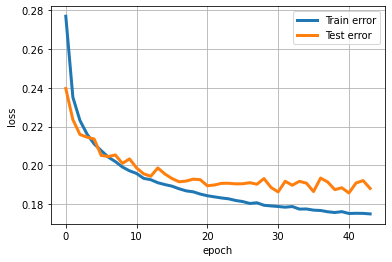

In [43]:
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [44]:
np.argmin(test_loss_history)

40

In [45]:
test_loss_history[43:45]

[0.18805781634352145]

In [46]:
correct = 0
total = 0

net.eval()
for i, data in enumerate(test_dataloader):
    with torch.no_grad():
        a_inp, a_out = data
        predicted_output = net(a_inp)
        p_arr = predicted_output.detach().numpy()
        a_out = a_out.detach().numpy()
        for i in range(len(a_out)):
            if abs(p_arr[i] - a_out[i])<0.5:
                correct += 1
            total += 1

print('accuracy is',correct/total)

accuracy is 0.9272812968168734


In [538]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
lin1.weight 	 torch.Size([128, 43])
lin1.bias 	 torch.Size([128])
lin2.weight 	 torch.Size([64, 128])
lin2.bias 	 torch.Size([64])
lin3.weight 	 torch.Size([32, 64])
lin3.bias 	 torch.Size([32])
lin4.weight 	 torch.Size([1, 32])
lin4.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'step': 2339250, 'exp_avg': tensor([[-1.4044e-03, -1.6014e-03, -1.6245e-04,  ...,  1.3960e-04,
         -5.2881e-04, -1.3035e-03],
        [-1.0559e-03, -7.8071e-04, -5.9011e-04,  ..., -4.1285e-05,
         -4.6616e-05, -9.2205e-04],
        [ 3.5159e-03,  4.9848e-03, -8.0942e-04,  ..., -4.4663e-06,
          1.5733e-03,  1.7720e-03],
        ...,
        [ 2.3195e-03,  1.8948e-03,  6.6652e-04,  ..., -1.3658e-04,
          2.7860e-04,  1.6638e-03],
        [-2.4400e-03, -1.0067e-03, -6.4062e-04,  ..., -5.8464e-04,
          7.7969e-04, -1.5276e-03],
        [-3.8351e-04, -5.7891e-04, -1.1470e-04,  ..., -4.9376e-04,
         -9.9262e-04, -3.9632e-04]]), 'exp_avg_sq': tensor([[4.

In [48]:
# torch.save(net.state_dict(),'model_checkpoint_one.state')
torch.save(net.state_dict(),'model_checkpoint_two.state')

In [47]:
num_feat

55

In [ ]:
# To save a model, I need: 
# 1. Standard scaler
# 2. input columns in order
# 3. model state dict
# 4. code for the model class

# saving a model running code:
# torch.save(net.state_dict(),'model_checkpoint_one.state')
# pickle columns and standard scaler
# store a copy of model class

# Loading a model sampe code:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [49]:
import pickle
cols_one = input_cols
with open('columns_two.pkl', 'wb') as handle:
    pickle.dump(cols_one, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('scaler_two.pkl', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# checkpoint 1 get data function:
# def get_data(num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,space_left_c,space_left_p):
#     data = dict()
    
#     data['l_c_dist'] = len(c_dist)
#     data['l_dist'] = len(dist)
    
#     if space_left_p:
#         data['space_left_p_mean'] = np.mean(space_left_p)
#         data['space_left_p_std'] = np.std(space_left_p)
    
#     if space_left_c:
#         data['space_left_c_mean'] = np.mean(space_left_c)
#         data['space_left_c_std'] = np.std(space_left_c)

#     # get 2,3 moment of num
#     max_moments = 3
#     for i in range(2,max_moments+1):
#         data[str(i)+'_num_moment'] = stats.moment(num,i)
#         data[str(i)+'_c_num_moment'] = stats.moment(c_num,i)

#     # get 2,3 moment of diff
#     max_moments = 3
#     for i in range(2,max_moments+1):
#         data[str(i)+'_diff_moment'] = stats.moment(diff,i)
#         data[str(i)+'_c_diff_moment'] = stats.moment(c_diff,i)

#     # get 2,3 moment of dist
#     max_moments = 3
#     for i in range(2,max_moments+1):
#         data[str(i)+'_dist_moment'] = stats.moment(dist,i)
#         data[str(i)+'_c_dist_moment'] = stats.moment(c_dist,i)

#     # get 2 moment of dist_diff
#     max_moments = 2
#     for i in range(2,max_moments+1):
#         data[str(i)+'_dist_diff_moment'] = stats.moment(dist_diff,i)
#         data[str(i)+'_c_dist_diff_moment'] = stats.moment(c_dist_diff,i)

#     # get 3 moment of dist_diff*1000
#     data[str(3)+'_dist_diff_moment'] = stats.moment(dist_diff,3) * 1000
#     data[str(3)+'_c_dist_diff_moment'] = stats.moment(c_dist_diff,3) * 1000

#     # dependant stats
#     if num and c_num:
#         data['num_p_ks'] = stats.ks_2samp(num,c_num)[1]
#     if dist and c_dist:
#         data['dist_p_ks'] = stats.ks_2samp(dist,c_dist)[1]
#     if diff and c_diff:
#         data['diff_p_ks'] = stats.ks_2samp(diff,c_diff)[1]
#     if dist_diff and c_dist_diff:
#         data['dist_diff_p_ks'] = stats.ks_2samp(dist_diff,c_dist_diff)[1]

#     # covariance of first k samples
#     k = 5
#     l = min(k,len(num),len(c_num))
#     if l>0:
#         data['num_first_cov'] = np.cov(num[:l],c_num[:l])[0][1]
#         data['num_last_cov'] = np.cov(num[-l:],c_num[-l:])[0][1]

#     l = min(k,len(dist),len(c_dist))
#     if l>0:
#         data['dist_first_cov'] = np.cov(dist[:l],c_dist[:l])[0][1]
#         data['dist_last_cov'] = np.cov(dist[-l:],c_dist[-l:])[0][1]

#     l = min(k,len(diff),len(c_diff))
#     if l>0:
#         data['diff_first_cov'] = np.cov(diff[:l],c_diff[:l])[0][1]
#         data['diff_last_cov'] = np.cov(diff[-l:],c_diff[-l:])[0][1]

#     l = min(k,len(dist_diff),len(c_dist_diff))
#     if l>0:
#         data['dist_diff_first_cov'] = np.cov(dist_diff[:l],c_dist_diff[:l])[0][1]
#         data['dist_diff_last_cov'] = np.cov(dist_diff[-l:],c_dist_diff[-l:])[0][1]
#     return data

# checkpoint 1 get model:
# class NeuralNet(torch.nn.Module): 
#     def __init__(self):
#         super(NeuralNet,self).__init__()

#         self.relu = torch.nn.ReLU()
        
#         self.lin1 = torch.nn.Linear(num_feat, 128)
        
#         self.lin2 =torch.nn.Linear(128, 64)
        
#         self.dropout = torch.nn.Dropout(p=0.2)
        
#         self.lin3 =torch.nn.Linear(64, 32)
        
#         self.lin4 =torch.nn.Linear(32, 1)
        
#         self.out = torch.nn.Sigmoid()
        
#         self.float()
        
#     def forward(self, x):
#         x = self.lin1(x)
#         x = self.relu(x)
        
#         x = self.lin2(x)
#         x = self.relu(x)
        
#         x = self.dropout(x)
        
#         x = self.lin3(x)
#         x = self.relu(x)
        
#         x = self.lin4(x)
#         x = self.out(x)
        
#         return x

# net = NeuralNet()
# loss = torch.nn.BCELoss() # pass output, target
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Load model sample code
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [ ]:
# training code for model 2
# # create dataset
# df = pd.DataFrame()

# # get distributions for plaintexts
# rel_dist_all = [build_rel_dist(text) for text in TEST_PLAIN_TEXTS]
# rel_dists = [a[0] for a in rel_dist_all]
# rel_nums = [a[1] for a in rel_dist_all]

# rel_dist_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_dists]
# rel_num_diffs = [defaultdict(list,{k:get_diff(v) for k,v in dist.items()}) for dist in rel_nums]

# # space_left_ps = []
# # for i,txt in enumerate(TEST_PLAIN_TEXTS):
# #     space_left_ps.append(
# #         defaultdict(list,{c:get_space_diffs_left(rel_nums[i][' '],rel_nums[i][c]) for c in _ALPHABET})
# #     )
# space_data_ps = []
# for i,txt in enumerate(TEST_PLAIN_TEXTS):
#     space_data_ps.append(
#         defaultdict(list,{c:get_space_diffs_data(rel_nums[i][' '],rel_nums[i][c],len(txt)) for c in _ALPHABET})
#     )
    
# num_itr = 0
# for r_idx,cipher,char_key_mapping in iter_prob_tests(5,75,2,90):
#     # track progress
#     num_itr += 1
#     if num_itr % 10 == 0:
#         print(num_itr)
    
#     rev_mapping = {v:k for k,v in char_key_mapping.items()}
    
#     char_diff = len(cipher) - len(TEST_PLAIN_TEXTS[r_idx])
    
#     # get distributions for cipher
#     c_rel_dist,c_rel_num = build_rel_dist(cipher)
#     c_rel_num_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_num.items()})
#     c_rel_dist_diff = defaultdict(list,{k:get_diff(v) for k,v in c_rel_dist.items()})
#     space_char = decrypt.get_space_key_value(cipher)
# #     space_left_c = defaultdict(list,{c:get_space_diffs_left(c_rel_num[space_char],c_rel_num[c]) for c in _ALPHABET})
#     space_data_c = defaultdict(list,{c:get_space_diffs_data(c_rel_num[space_char],c_rel_num[c],len(cipher)) for c in _ALPHABET})
    
#     for c_c in _ALPHABET:
#         c_p = rev_mapping[c_c]
        
#         num = rel_nums[r_idx][c_p]
#         c_num = c_rel_num[c_c]
        
#         dist = rel_dists[r_idx][c_p]
#         c_dist = c_rel_dist[c_c]
        
#         diff = rel_num_diffs[r_idx][c_p]
#         c_diff = c_rel_num_diff[c_c]
        
#         dist_diff = rel_dist_diffs[r_idx][c_p]
#         c_dist_diff = c_rel_dist_diff[c_c]
        
#         data = get_data(num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,space_data_c[c_c],space_data_ps[r_idx][c_p])
#         data['char_diff'] = char_diff
#         data['output'] = 1
#         append(data,df)
        
#         best_negative = get_best_negative(r_idx,c_dist,rel_dists,3)
        
#         chosen = set([c_p])
#         while len(chosen)<4:
#             c_p = next_choice(best_negative,chosen)
#             chosen.add(c_p)
            
#             num = rel_nums[r_idx][c_p]
#             dist = rel_dists[r_idx][c_p]
#             diff = rel_num_diffs[r_idx][c_p]
#             dist_diff = rel_dist_diffs[r_idx][c_p]
            
#             data = get_data(num,diff,dist,dist_diff,c_num,c_diff,c_dist,c_dist_diff,space_data_c[c_c],space_data_ps[r_idx][c_p])
#             data['char_diff'] = char_diff
#             data['output'] = 0
#             append(data,df)
            